In [1]:
import torch
import torch.nn as nn
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline

import get_spectra
import importlib

### load crossmatch

In [5]:
xmatch = Table.read("../cats/apogee-dr16-lamost-dr5v3.fits")
xmatch = xmatch[xmatch["SNR"] > 300]
xmatch = xmatch[xmatch["snrz"] > 300]
#xmatch = xmatch[np.logical_and(xmatch["COMMISS"] == 0, xmatch["STARFLAG"] != 1)] #hacks, hacks, hacks
len(xmatch)

5616

### download APOGEE spectra

of 3591 spectra, 0 need to be downloaded


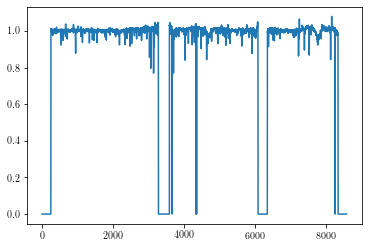

In [4]:
get_spectra.download_apogee_spectra(xmatch)
flux, err = get_spectra.load_apogee_spectrum(xmatch[1])
plt.plot(flux)
npix1 = flux.shape[0]

### download LAMOST spectra

of 3591 spectra, 0 need to be downloaded


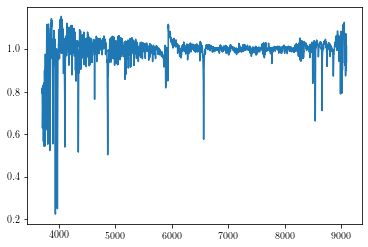

In [5]:
importlib.reload(get_spectra)
get_spectra.download_lamost_spectra(xmatch["obsid"])
wl, flux, ivar = get_spectra.load_lamost_spectrum(xmatch["obsid"][0])
plt.plot(wl, flux)
npix2 = flux.shape[0]

### organize data

In [6]:
nstar = len(xmatch)
F1 = torch.empty(npix1, nstar)
F2 = torch.empty(npix2, nstar)
E2 = torch.empty(npix2, nstar) 
for i, row in enumerate(xmatch):
    flux, _ = get_spectra.load_apogee_spectrum(row)
    F1[:, i] = torch.from_numpy(flux.byteswap().newbyteorder())
    _, flux, err = get_spectra.load_lamost_spectrum(row['obsid'])
    F2[:, i] = torch.from_numpy(flux)
    E2[:, i] = torch.from_numpy(np.power(err, -0.5))
    
F2[torch.isnan(F2)] = 0.0
E2[torch.isnan(E2)] = 100.
E2[F2 == float("inf")] = float("inf")
F2[F2 == float("inf")] = 0.0

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.
/Users/aw/Dropbox/stereo/get_spectra.py:66: RuntimeWarning: invalid value encountered in true_divide
  flux /= cont
/Users/aw/Dropbox/stereo/get_spectra.py:53: RuntimeWarning: invalid value encountered in float_scalars
  yield np.sum(weights * fluxes[indices])/np.sum(weights)
/Users/aw/Dropbox/stereo/get_spectra.py:66: RuntimeWarning: divide by zero encountered in true_divide
  flux /= cont


In [7]:
label_names = ["TEFF_1", "LOGG_1", "FE_H", "O_FE"]
label_err_names = ["TEFF_ERR_1", "LOGG_ERR_1", "FE_H_ERR", "O_FE_ERR"]
nlab = len(label_names)
labels = torch.empty(nlab, nstar)
label_err = torch.empty(nlab, nstar)
for i, (ln, en) in enumerate(zip(label_names, label_err_names)):
    labels[i, :] = torch.from_numpy(xmatch[ln].data.byteswap().newbyteorder())
    label_err[i, :] = torch.from_numpy(xmatch[en].data.byteswap().newbyteorder())

In [9]:
mask = ~torch.any(labels == -9999, 0)
F1 = F1[:, mask]
F2 = F2[:, mask]
E2 = E2[:, mask]
labels = labels[:, mask]
label_err = label_err[:, mask]
nstars = torch.sum(mask).item()

(array([1.400e+01, 2.160e+02, 1.317e+03, 6.850e+02, 2.440e+02, 2.170e+02,
        9.500e+01, 1.300e+01, 4.000e+00, 1.000e+00]),
 array([-0.22496563, -0.14456427, -0.06416292,  0.01623843,  0.09663979,
         0.17704114,  0.2574425 ,  0.33784387,  0.4182452 ,  0.49864656,
         0.5790479 ], dtype=float32),
 <a list of 10 Patch objects>)

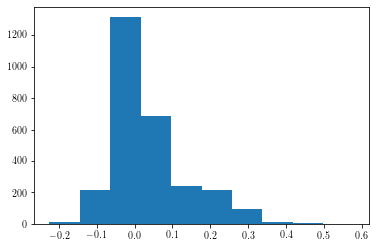

In [15]:
plt.hist(labels[3, :])

### define NN

In [723]:
class Net(nn.Module):
    def __init__(self, len1, len2, k=10):
        super(Net, self).__init__()
        #self.fc1 = nn.Linear(len1, 100)
        #self.fc2 = nn.Linear(100, k)
        #self.fc3 = nn.Linear(k, 100)
        #self.fc4 = nn.Linear(100, len2)
        self.fc1 = nn.Linear(len1, k)
        self.fc2 = nn.Linear(k, len2)
        
    def forward(self, x):
        x = self.fc1(x)
        return self.fc2(x)
        #x = self.fc2(x)
        #x = self.fc3(x)
        #return self.fc4(x)

In [18]:
def calc_z(F1, βz, bz):
    return torch.matmul(F1.transpose(0,1), βz) + bz 

def calc_mu_F2(z, βF, bF):
    return (torch.matmul(z, βF) + bF).transpose(0,1)

def calc_mu_l(z, βl, bl):
    return (torch.matmul(z, βl) + bl).transpose(0,1)

def log_joint(F1, F2, E2, l, el, βz, bz, βF, bF, βl, bl): 
    lj  = 0.0
    #TODO priors on latent variables
    
    #likelihood
    z = calc_z(F1, βz, bz)
    mu_F2 = calc_mu_F2(z, βF, bF)
    mu_l = calc_mu_l(z, βl, bl)
    lj -= 0.5*torch.sum(((F2 - mu_F2)/E2)**2)
    lj -= 0.5*torch.sum(((l - mu_l)/el)**2)
    
    return lj

def simple_log_joint(F1, F2, E2,  βz, bz, βF, bF): 
    lj  = 0.0
    #TODO priors on latent variables
    
    #likelihood
    z = calc_z(F1, βz, bz)
    mu_F2 = calc_mu_F2(z, βF, bF)
    lj -= 0.5*torch.sum(((F2 - mu_F2)/E2)**2)
    
    return lj

In [19]:
c = 3
βz = torch.randn(npix1, c, requires_grad=True)
bz = torch.randn(c, requires_grad=True)
βF = torch.randn(c, npix2, requires_grad=True)
bF = torch.randn(npix2, requires_grad=True)
βl = torch.randn(c, nlab)
bl = torch.randn(nlab, requires_grad=True)

In [ ]:
import torch.optim as optim

ljs = []
epochs = 20000
batch_prob = 0.05
optimizer = optim.Adam([βz, bz, βF, bF, βl, bl], lr=0.1)
#optimizer = optim.Adam([βz, bz, βF, bF], lr=0.01)
for epoch in range(epochs):
    optimizer.zero_grad()
    mask = torch.FloatTensor(nstars).uniform_() < batch_prob
    lj = log_joint(F1[:, mask], F2[:, mask], E2[:, mask], labels[:, mask], label_err[:, mask], βz, bz, βF, bF, βl, bl)
    #lj = simple_log_joint(F1[:, mask], F2[:, mask], E2[:, mask], βz, bz, βF, bF)
    ljs.append(lj.item())
    (-lj).backward()
    optimizer.step()

In [ ]:
plt.plot(range(epochs), np.array(ljs), label="log likelihood")
plt.yscale("symlog")
plt.legend()
plt.xlabel("optimization step")

In [ ]:
pF2 = calc_mu_F2(calc_z(F1, βz, bz), βF, bF).detach()
i = 5
plt.figure(figsize=(12, 4))
axs = plt.subplots(2, 1, figsize=(12, 5))[1]

plt.sca(axs[0])
plt.plot(F2[:, i].numpy(), alpha=0.7)
plt.plot(pF2[:, i].numpy(), alpha=0.7)
#plt.ylim(0, 2)

plt.sca(axs[1])
plt.plot(((pF2[:, i]-F2[:, i])/E2[:, i]).numpy(), c="k", zorder=0)
plt.axhline(0.0, ls="--", c="grey", zorder=1)

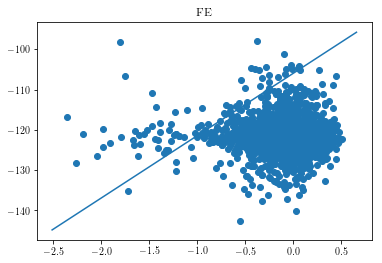

In [758]:
mu_z = calc_z(F1, βz, bz)
pl = calc_mu_l(mu_z,βl, bl)

i = 2
plt.title(label_names[i].split("_")[0])
plt.scatter(labels[i, :], pl[i, :].detach().numpy())
plt.plot([*plt.xlim()], [*plt.ylim()])

In [711]:
np.where((pl[2, :] > 20).detach().numpy())

(array([2921]),)

In [705]:
torch.sum(pl[2, :] > 20)

TypeError: sum(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

# MLE $z|F2, E_2$

In [255]:
for i in range(1500):
    invΣ = np.diag((E2[i, :]**(-1)).detach().numpy())
    f = (F2[i, :] - b).detach().numpy()
    z[:, i] = np.linalg.solve(np.matmul(np.matmul(θ.transpose(), invΣ), θ), 
                                  np.matmul(np.matmul(θ.transpose(), invΣ), f))

/Users/adamwheeler/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in matmul
  


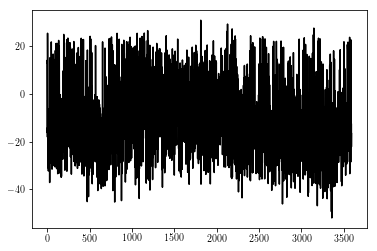

In [647]:
plt.plot(calc_z(F1, βz, bz).detach().numpy(), c="k");

(3909, 50)
(50,)


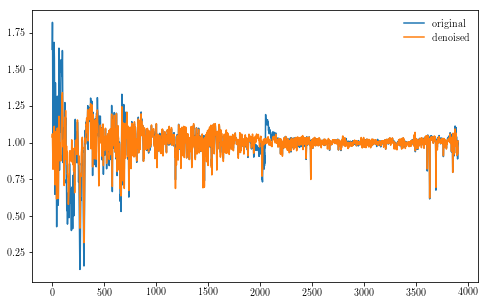

In [259]:
i = 7

print(θ.shape)
print(z[:, i].shape)

plt.figure(figsize=(8,5))
plt.plot(F2[i, :].detach().numpy(), label="original")
plt.plot(np.matmul(θ,z[:, i]) + b.detach().numpy(), label="denoised")
plt.legend()

# now, try to infer teffs from $z$

/Users/adamwheeler/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


0.08421352122956133

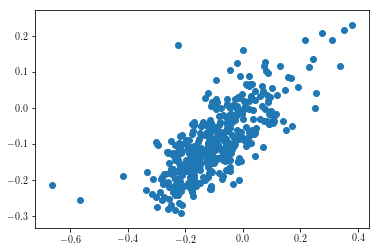

In [395]:
s = "CI_FE"
mask = (xmatch[s][500:1000] != -9999)
teffs = np.array(xmatch[s][500:1000][mask])

mu_z = np.mean(z[:, 500:1000][:, mask], 1)
pivoted_z = z[:, 500:1000][:, mask].transpose() - mu_z
pivoted_z = np.hstack((np.ones((pivoted_z.shape[0], 1)), pivoted_z))
res = np.linalg.lstsq(pivoted_z, teffs)
β = res[0]

inferred_teffs = np.matmul(pivoted_z, β)
plt.scatter(teffs, inferred_teffs)

np.std(teffs-inferred_teffs)